# Macro Facial Expressions detection using keras

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

train_filepath="C:\\Users\\MSI\\Desktop\\DL\\Datasets\\MMAFEDB\\train\\"
test_filepath="C:\\Users\\MSI\\Desktop\\DL\\Datasets\\MMAFEDB\\test\\"

Tensorflow version: 2.6.0


## Exploring the FER image dataset

In [2]:
def plot_example_images(plt):
    img_size = 48
    plt.figure(0, figsize=(12,20))
    ctr = 0
    for expression in os.listdir(train_filepath):
        for i in range(1,6):
            ctr += 1
            plt.subplot(7,5,ctr)
            img = load_img(train_filepath + expression + "\\" +os.listdir(train_filepath + expression)[i], target_size=(img_size, img_size))
            plt.imshow(img, cmap="gray")

    plt.tight_layout()
    return plt

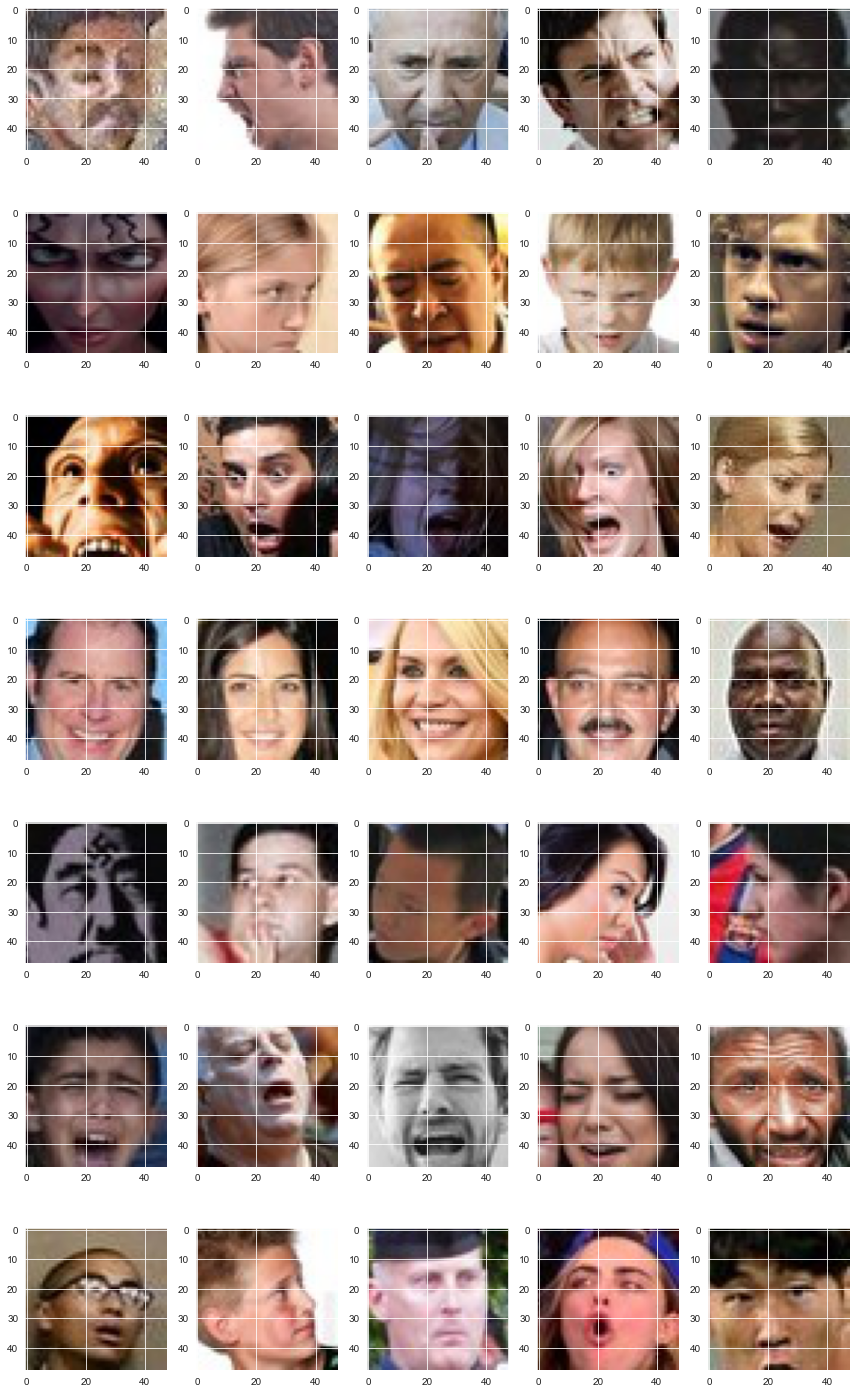

In [3]:
plot_example_images(plt).show()

In [4]:
for expression in os.listdir(train_filepath):
    print(str(len(os.listdir(train_filepath + expression )))+" "+ expression+ " images")

10561 angry images
3667 disgust images
8956 fear images
35806 happy images
34349 neutral images
17053 sad images
11284 surprise images


## Defining the CNN model

In [5]:
img_size= 48
batch_size= 64
datagen_train =  ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory(train_filepath,target_size=(img_size,img_size),color_mode='grayscale', batch_size=batch_size,class_mode='categorical',shuffle=True)
datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_train.flow_from_directory(test_filepath,target_size=(img_size,img_size),color_mode='grayscale', batch_size=batch_size,class_mode='categorical',shuffle=True)

Found 121676 images belonging to 7 classes.
Found 24534 images belonging to 7 classes.


In [6]:
model = Sequential()

#1 - conv
model.add(Conv2D(64,(3,3),padding='same',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#2 conv
model.add(Conv2D(128,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#3 conv
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# conv
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

## Training the model

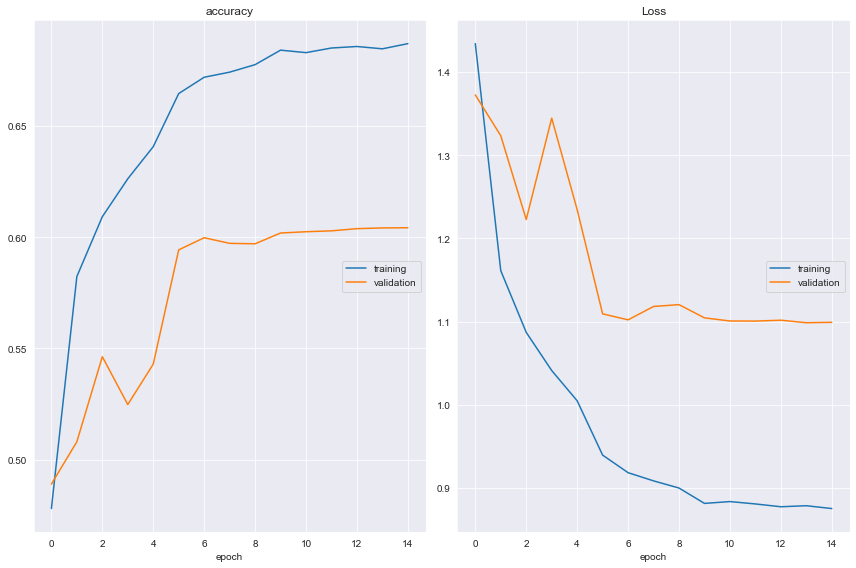

accuracy
	training         	 (min:    0.478, max:    0.687, cur:    0.687)
	validation       	 (min:    0.489, max:    0.604, cur:    0.604)
Loss
	training         	 (min:    0.875, max:    1.434, cur:    0.875)
	validation       	 (min:    1.099, max:    1.373, cur:    1.099)

Epoch 00015: saving model to model_weights.h5


In [7]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("mma_model_weights.h5", monitor='val_accuracy', save_weights_only=True,mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2, min_lr=0.00001,model='auto')
callbacks = [PlotLossesKerasTF(),checkpoint, reduce_lr]

history = model.fit(x=train_generator,steps_per_epoch=steps_per_epoch,epochs=epochs,validation_data=validation_generator,validation_steps=validation_steps, callbacks=callbacks)

In [8]:
model_json = model.to_json()
with open("mma_model.json","w") as json_file:
    json_file.write(model_json)